# Book Recommendation Project     

Have you ever wondered for a system which suggest a new set of books for your previously read books !?.   
Well [Recommendation Systems](https://en.wikipedia.org/wiki/Recommender_system#:~:text=A%20recommender%20system%2C%20or%20a,would%20give%20to%20an%20item.) are there to help, they are very common to us due to continuous demand and need to get the best book to read.  

In this Project we analyse and preprocess the [Book Crossing Dataset](https://www.kaggle.com/mohitnirgulkar/book-recommendation-data) collected by [Cai-Nicolas Ziegler](http://www2.informatik.uni-freiburg.de/~cziegler/BX/)   
and apply Machine Learning to recommend different books from a book you previously read.   
Whole code below is in [Python](https://www.python.org/) using various libraries. Open source library [Scipy](https://www.scipy.org/) is used for preprocessing and [Scikit-Learn](https://scikit-learn.org/) is used for creating the model.


# 1. Dependancies and Dataset

### Importing Dependancies

In [73]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
import string
import re

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# change defaults
sns.set_context('paper')
sns.set_style('darkgrid')
sns.set_palette('rainbow')

### Importing Datasets

In [5]:
#Columns Names
book_cols = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
rating_cols = ['userId','ISBN','bookRating']
user_cols = ['userId','location','age']

books = pd.read_csv('BX-Books.csv',
                    sep=';', error_bad_lines=False, encoding='latin-1')
books.columns = book_cols

ratings = pd.read_csv('BX-Book-Ratings.csv',
                      sep=';', error_bad_lines=False, encoding='latin-1')
ratings.columns = rating_cols

users = pd.read_csv('BX-Users.csv',
                    sep=';', error_bad_lines=False, encoding='latin-1')
users.columns = user_cols

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


Displaying first two entries of Books data using [DataFrame.head()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html)

In [6]:
books.head(2)

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...


Displaying first two entries of Ratings data

In [7]:
ratings.head(2)

,userId,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5


Displaying first two entries of users Data

In [8]:
users.head(2)

,userId,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0


# 2. Data Cleaning

### Checking Books Data

Using [DataFrame.info()](https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.DataFrame.info.html) method to check number of null values and Data types of the data

In [9]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   ISBN               271360 non-null  object
 1   bookTitle          271360 non-null  object
 2   bookAuthor         271359 non-null  object
 3   yearOfPublication  271360 non-null  object
 4   publisher          271358 non-null  object
 5   imageUrlS          271360 non-null  object
 6   imageUrlM          271360 non-null  object
 7   imageUrlL          271357 non-null  object
dtypes: object(8)
memory usage: 8.3+ MB


Column yearOfPublication should be set having dtype as int, hence checking the unique values of yearOfPublication using [Series.unique()](https://pandas.pydata.org/docs/reference/api/pandas.Series.unique.html) method

In [10]:
books.yearOfPublication.unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

We can observe from above that some author names are mixed up in year data like 'DK Publishing Inc' and 'Gallimard'  
Checking the rows having 'DK Publishing Inc' as yearOfPublication using [DataFrame.loc[]](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html) method

In [11]:
books.loc[books.yearOfPublication == 'DK Publishing Inc',:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


Data of 2 books is to be corrected

Checking the rows having 'Gallimard' as yearOfPublication

In [12]:
books.loc[books.yearOfPublication == 'Gallimard',:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN


Storing Image URLs in different DataFrame because we don't need them now

In [14]:
books_data = books[['ISBN', 'bookTitle','imageUrlS', 'imageUrlM', 'imageUrlL']]
books = books[['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher']]

Verifying the changes in publication year 

Converting year data from object type to numeric using [pd.to_numeric](https://pandas.pydata.org/docs/reference/api/pandas.to_numeric.html) and if error occurs replacing them with NAN values

In [15]:
books.yearOfPublication = pd.to_numeric(books.yearOfPublication, errors='coerce')

The value 0 for year is invalid and as this dataset was published in 2004, I have assumed the the years after 2021 to be 
invalid keeping some margin in case dataset was updated thereafer setting invalid years as NaN

In [16]:
books.loc[(books.yearOfPublication > 2021) | (books.yearOfPublication == 0),'yearOfPublication'] = np.NAN

Using [Series.fillna()](https://pandas.pydata.org/docs/reference/api/pandas.Series.fillna.html) to fill the NAN values with mean value of the years and then converting data type to int

In [17]:
books.yearOfPublication.fillna(round(books.yearOfPublication.mean()),inplace=True)
convert_dict = {'yearOfPublication': np.int64,}
books = books.astype(convert_dict)

Checking if there are NULL values present in publisher column using [Series.isnull()](https://pandas.pydata.org/docs/reference/api/pandas.Series.isnull.html)

In [18]:
books.loc[books.publisher.isnull(),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


Checking with rows having bookTitle as Tyrant Moon to see if we can get any clues

In [19]:
books.loc[(books.bookTitle == 'Tyrant Moon'),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN


No clues for Tyrant Moon , Hence checking with rows having bookTitle as Finders Keepers to see if we can get any clues

In [20]:
books.loc[(books.bookTitle == 'Finders Keepers'),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
10799,082177364X,Finders Keepers,Fern Michaels,2002,Zebra Books
42019,0070465037,Finders Keepers,Barbara Nickolae,1989,McGraw-Hill Companies
58264,0688118461,Finders Keepers,Emily Rodda,1993,Harpercollins Juvenile Books
66678,1575663236,Finders Keepers,Fern Michaels,1998,Kensington Publishing Corporation
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN
134309,0156309505,Finders Keepers,Will,1989,Voyager Books
173473,0973146907,Finders Keepers,Sean M. Costello,2002,Red Tower Publications
195885,0061083909,Finders Keepers,Sharon Sala,2003,HarperTorch
211874,0373261160,Finders Keepers,Elizabeth Travis,1993,Worldwide Library


No clues here either as every book has different publishers , So checking  with rows having author Elaine Corvidae and Linnea Sinclair

In [21]:
books.loc[(books.bookAuthor == 'Elaine Corvidae') | (books.bookAuthor == 'Linnea Sinclair'),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
126762,1931696934,Winter's Orphans,Elaine Corvidae,2001,Novelbooks
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129001,0759901880,Wolfkin,Elaine Corvidae,2001,Hard Shell Word Factory
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


Assinging the Null publisher values as 'Unknown'

In [22]:
books.loc[(books.ISBN == '193169656X'),'publisher'] = 'Unknown'
books.loc[(books.ISBN == '1931696993'),'publisher'] = 'Unknown'

Checking for Null bookAuthor names 

In [23]:
books.loc[books.bookAuthor.isnull(),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing


Lets give the Null bookAuthor value as 'Unknown'

In [24]:
books.loc[(books.ISBN == '9627982032'),'bookAuthor'] = 'Unknown'

### Checking Users Data

Checking for number of null values and data types of data provided inside columns

In [25]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   userId    278858 non-null  int64  
 1   location  278858 non-null  object 
 2   age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 5.3+ MB


Age values below 4 and above 90 does not make much sense for our book rating case, hence replacing these by NANs

In [26]:
users.loc[(users.age > 90) | (users.age < 4), 'age'] = np.nan

Replacing NANs with mean value of users and converting data type to int

In [27]:
users.age = users.age.fillna(users.age.mean())
users.age = users.age.astype(np.int64)

### Checking Ratings Data

Checking for Null values and data types of Ratings data

In [28]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   userId      1149780 non-null  int64 
 1   ISBN        1149780 non-null  object
 2   bookRating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 21.9+ MB


Looks like it doesn't have any NAN values, So let's have a look at bookRating values

In [29]:
ratings.bookRating.unique()

array([ 0,  5,  3,  6,  8,  7, 10,  9,  4,  1,  2], dtype=int64)

bookRatings are always under 0-10, also Ratings dataset will have n_users $\times$ n_books entries if every user rated every item,

In [30]:

n_users = users.shape[0]
n_books = books.shape[0]
print(n_users * n_books)

75670906880


From above we can say that the dataset is very sparse,  
Ratings dataset should have books only which exist in our books dataset, unless new books are added to books dataset

In [31]:
ratings_new = ratings[ratings.ISBN.isin(books.ISBN)]

Also Ratings dataset should have ratings from users which exist in users dataset, unless new users are added to users dataset

In [32]:
ratings_new = ratings_new[ratings_new.userId.isin(users.userId)]
#Note: All users who rated are already inside users dataset

Dataset [Sparsity](https://campus.datacamp.com/courses/recommendation-engines-in-pyspark/recommending-movies?ex=3) Calculation

In [33]:
sparsity = 1 - (len(ratings_new)/(n_users*n_books))
print("No. of users = " + str(n_users) + ", No. of Books = " + str(n_books) 
      + "\nThe Following Dataset has " + str(sparsity*100) + " % Sparsity")

No. of users = 278858, No. of Books = 271360
The Following Dataset has 99.99863734155898 % Sparsity


Making two new ratings dataframes where ratings which are other than 0 are present and vice a versa

In [34]:
rating_explicit = ratings_new.loc[ratings_new.bookRating != 0, :]
rating_implicit = ratings_new.loc[ratings_new.bookRating == 0, :]
print("Explicit Ratings data shape = " + str(rating_explicit.shape) + "\nImplicit Ratings data shape = " + str(rating_implicit.shape))

Explicit Ratings data shape = (383842, 3)
Implicit Ratings data shape = (647294, 3)


### Visualising Explicit Rating Counts

Using [Seaborn](https://towardsdatascience.com/seaborn-python-8563c3d0ad41) Library for ploting a [countplot](https://www.geeksforgeeks.org/countplot-using-seaborn-in-python/)

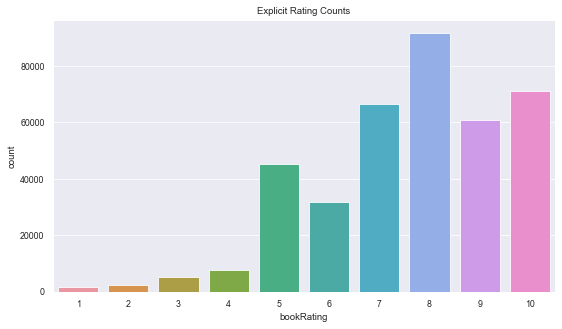

In [74]:
plt.figure(figsize=(9, 5))
plt.title('Explicit Rating Counts')
sns.countplot(x = 'bookRating', data = rating_explicit);

### Cleaning Title text

Function for cleaning title text using [Regex](https://en.wikipedia.org/wiki/Regular_expression) Library

In [36]:
def clean_text(text):
    #removal of url
    text = re.sub(r'https?://\S+|www\.\S+|http?://\S+',' ',text) 
    
    #removal of html tags
    text = re.sub(r'<.*?>',' ',text) 
    
    text = re.sub("["
                           u"\U0001F600-\U0001F64F"  # removal of emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+",' ',text)
    
    
    #remove newline char
    text = re.sub('\n', '', text)
    
    return text

Applying clean_text() function on bookTitle column

In [37]:
books.bookTitle = books.bookTitle.apply(lambda x:clean_text(x))

Merging Books and Ratings data using [pd.merge()](https://www.geeksforgeeks.org/python-pandas-merging-joining-and-concatenating/)

In [38]:
merged_data = pd.merge(books, ratings_new, on='ISBN')
merged_data =  merged_data.sort_values('ISBN', ascending=True)
merged_data.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,userId,bookRating
1013651,0000913154,The Way Things Work: An Illustrated Encycloped...,C. van Amerongen (translator),1967,Simon &amp; Schuster,171118,8
968138,0001010565,Mog's Christmas,Judith Kerr,1992,Collins,86123,0
968139,0001010565,Mog's Christmas,Judith Kerr,1992,Collins,209516,0
542150,0001046438,Liar,Stephen Fry,1994,Harpercollins Uk,23902,9
788100,0001046713,Twopence to Cross the Mersey,Helen Forrester,1992,HarperCollins Publishers,196149,0


# 3. Data Exploration

### Visualising top 30 most read books

Using [Series.value_counts()](https://pandas.pydata.org/docs/reference/api/pandas.Series.value_counts.html) and [sns.barplot](https://seaborn.pydata.org/generated/seaborn.barplot.html) for creating data and visualisation respectively

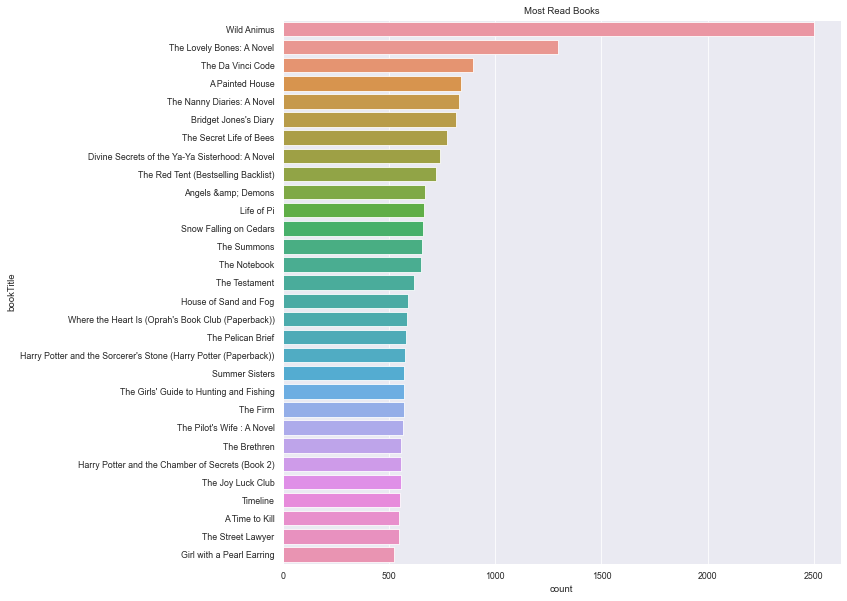

In [75]:
most_read = merged_data.bookTitle.value_counts().reset_index()
most_read.columns = ['bookTitle','count']

plt.figure(figsize = (10,10))
plt.title("Most Read Books")
sns.barplot(x = 'count', y = 'bookTitle', data = most_read.head(30));

### Top rated books(average rating according to number of users)

We may observe many books with average rating equal to 10 and 0 as many of the books are rated only once, hence this can't show us a good visualisation

In [40]:
top_rated = merged_data[['bookTitle','bookRating']]
top_rated = top_rated.groupby('bookTitle', as_index=False)['bookRating'].mean()
top_rated = top_rated.sort_values('bookRating',ascending=False).reset_index()
top_rated = top_rated[['bookTitle','bookRating']]

top_rated.head()

,bookTitle,bookRating
0,Film Is: The International Free Cinema,10.0
1,More Secrets of Happy Children: Embrace Your P...,10.0
2,Jo's Boys : From the Original Publisher,10.0
3,The Vanished Priestess : An Annie Szabo Mystery,10.0
4,Game and Hunting,10.0


In [41]:
top_rated.tail()

,bookTitle,bookRating
241066,Invaders of the Planet Earth (Choose Your Own ...,0.0
241067,Sammy Discovers the Alphabet (Learn-With-Sammy),0.0
241068,Sammy Carducci's Guide to Women,0.0
241069,Sammle mir Kiesel am FluÃ?Â?. Mehr als eine Li...,0.0
241070,TRAVELLING MAN,0.0


### Visualising top 30 most read books with there average ratings

Using [DataFrame.groupby()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) and [DataFrame.sort_values()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html) for ploting a barplot

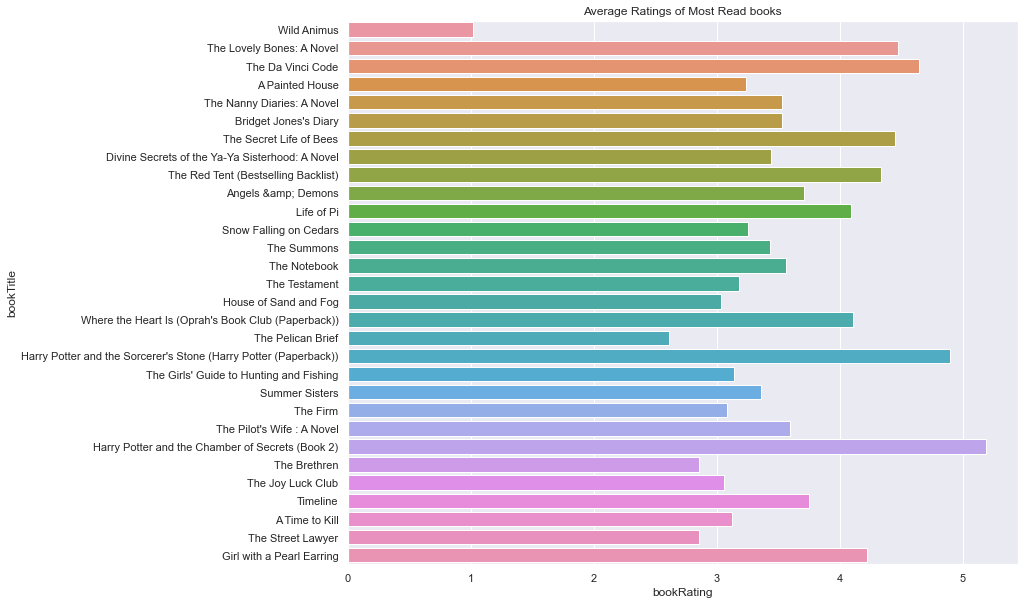

In [42]:
avg_data = merged_data.groupby('bookTitle', as_index=False)['bookRating'].mean()
temp = merged_data.bookTitle.value_counts().reset_index()
temp.columns = ['bookTitle','count']
most_rated_by_reads = pd.merge(avg_data,temp,on='bookTitle')

most_rated_by_reads = most_rated_by_reads.sort_values('count',ascending=False)

plt.figure(figsize=(12,10))
plt.title("Average Ratings of Most Read books")
sns.barplot(x = 'bookRating', y = 'bookTitle', data = most_rated_by_reads.head(30));

### Visualising Count of Books with a specific length

Creating title_length data for every title in bookTitle column and ploting a histplot

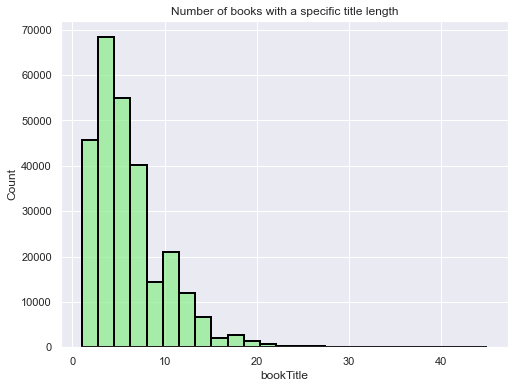

In [43]:
title_length = books.bookTitle.str.split().map(lambda x: len(x))
plt.figure(figsize=(8,6))
plt.title('Number of books with a specific title length')
sns.histplot(title_length, bins=25, color = 'lightgreen', linewidth = 2, edgecolor = 'black');

### Visualising top 30 years with most book being published

We count the number of times a book is published in a particular year and plot a barplot

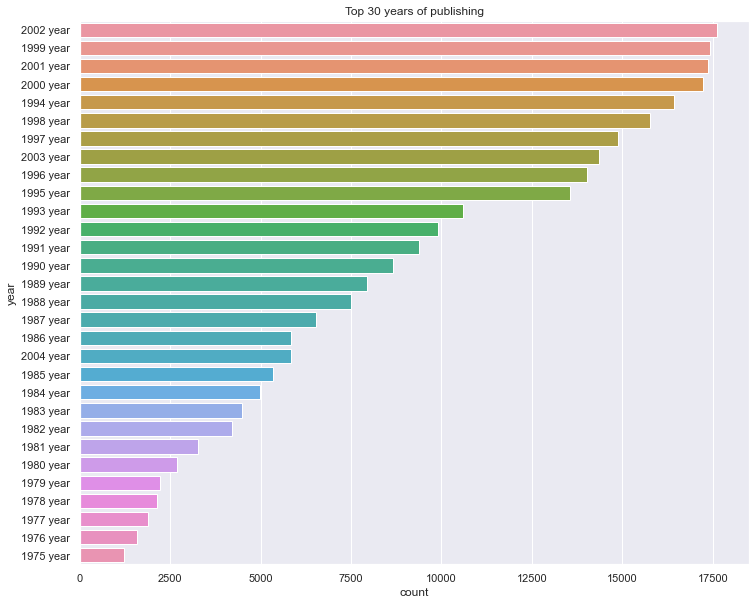

In [44]:
yearOP = books['yearOfPublication'].value_counts().reset_index()

yearOP.columns = ['value', 'count']

yearOP['year'] = yearOP['value'].astype(str) + ' year'

yearOP = yearOP.sort_values('count',ascending=False)

plt.figure(figsize=(12,10))
plt.title('Top 30 years of publishing')
sns.barplot(data = yearOP.head(30), x='count', y="year");

### Visualising top 30 authors with most books

We count the number of times a book written by an author and plot a barplot for the top 30 authors

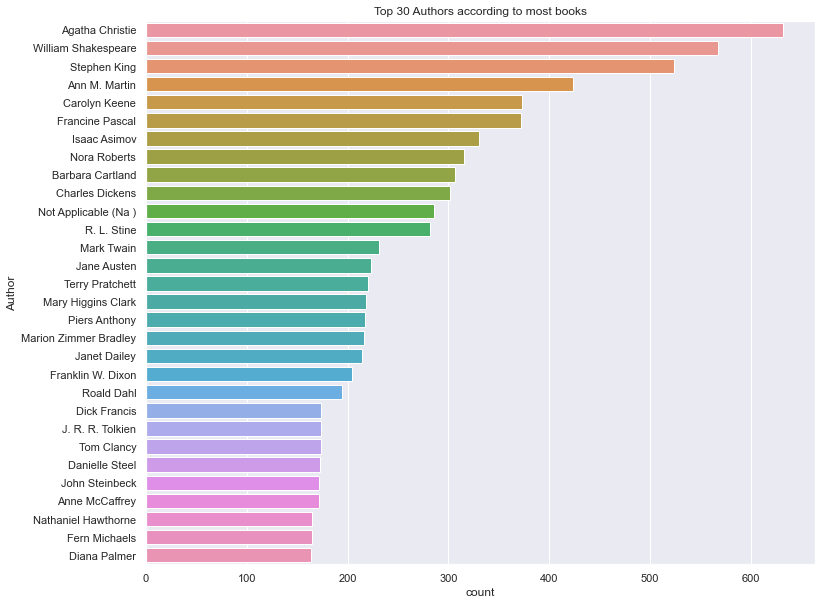

In [45]:
top_author = books['bookAuthor'].value_counts().reset_index()
top_author.columns = ['Author', 'count']
top_author['Author'] = top_author['Author']
top_author = top_author.sort_values('count',ascending=False)

plt.figure(figsize=(12,10))
plt.title('Top 30 Authors according to most books')
sns.barplot(data = top_author.head(30), x = 'count', y = 'Author');

### Visualising top 30 publishers with most books

We count the number of books published by a publisher and plot top 30 of them

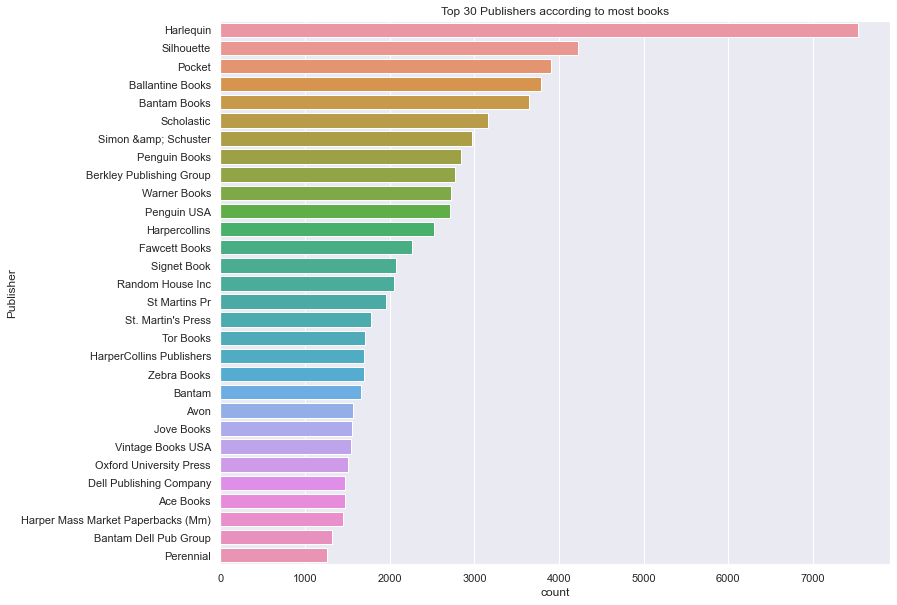

In [46]:
top_publisher = books['publisher'].value_counts().reset_index()
top_publisher.columns = ['Publisher', 'count']
top_publisher['Publisher'] = top_publisher['Publisher']
top_publisher = top_publisher.sort_values('count',ascending=False)

plt.figure(figsize=(12,10))
plt.title('Top 30 Publishers according to most books')
sns.barplot(data = top_publisher.head(30), x = 'count', y = 'Publisher');

### Visualising the age distribution of the users

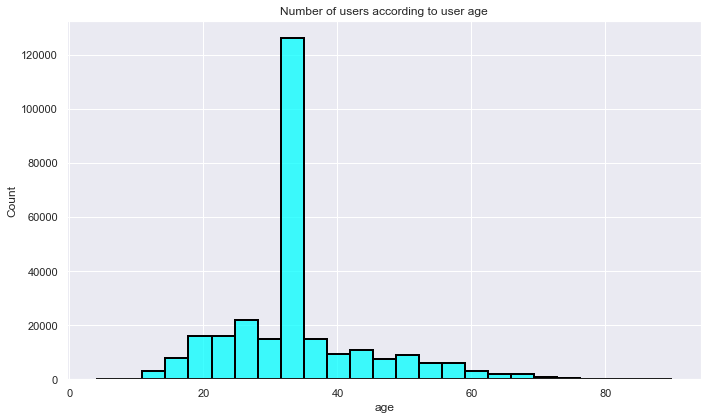

In [47]:
user_age = users.age
plt.figure(figsize=(10,6), tight_layout=True)
plt.title('Number of users according to user age')
sns.histplot(user_age, bins=25, linewidth = 2, color = 'cyan', edgecolor = 'black');

### Visualising most frequent words in Author, Title and Publisher string

Creating string variables for bookAuthor, bookTitle and publisher, also creating a function to plot [WordCloud()](https://www.geeksforgeeks.org/generating-word-cloud-python/) 

In [48]:
author_string = " ".join(books['bookAuthor'].astype(str))
title_string = " ".join(books['bookTitle'].astype(str))
publisher_string = " ".join(books['publisher'].astype(str))
stop_words = set(STOPWORDS)

def wordcloud(string,title ="unknown"):
    wc = WordCloud(width=800,height=500,mask=None,random_state=21,
                   stopwords=stop_words).generate(string)
    fig=plt.figure(figsize=(16,8))
    plt.title(title)
    plt.axis('off')
    plt.imshow(wc)

Displaying most frequent words in author names

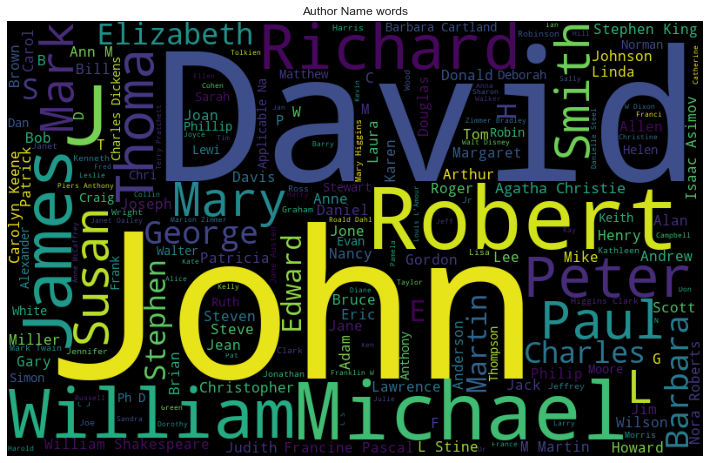

In [49]:
wordcloud(author_string,'Author Name words')

Displaying most frequent words in title text

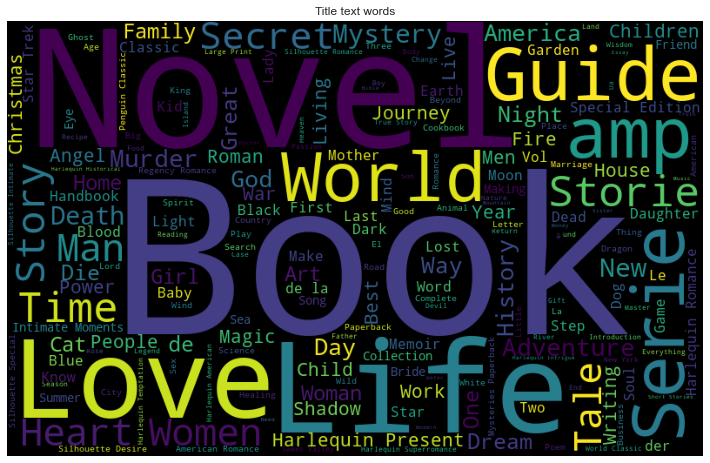

In [50]:
wordcloud(title_string,'Title text words')

Displaying most frequent words in publisher names

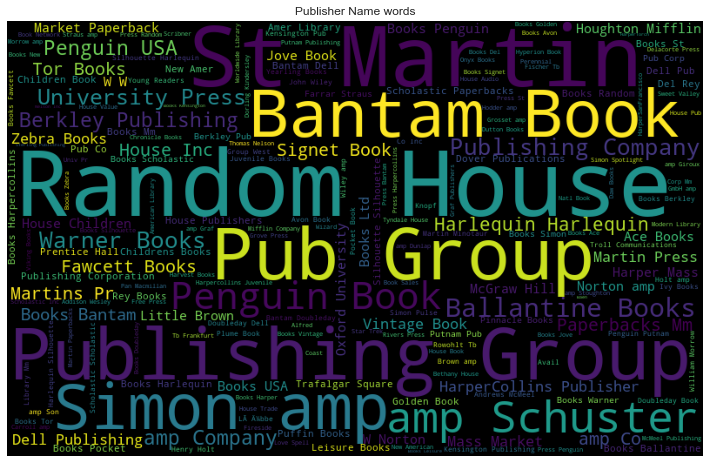

In [51]:
wordcloud(publisher_string,'Publisher Name words')

# 4. Popularity Based Recommendation

Below we show top 10 recommendations based on popularity using sum of bookRating values to choose which is popular.    
It is evident that books authored by [J.K. Rowling](https://www.jkrowling.com/) are one of the most popular

In [52]:
ratings_count = pd.DataFrame(rating_explicit.groupby(['ISBN'])['bookRating'].sum())
top_10 = ratings_count.sort_values('bookRating', ascending = False).head(10)
print("Following books are recommended")
top_10.merge(books, left_index = True, right_on = 'ISBN').reset_index()

Following books are recommended


,index,bookRating,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,408,5787,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
1,748,4108,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday
2,522,3134,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
3,2143,2798,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,Arthur A. Levine Books
4,356,2595,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books
5,26,2551,0971880107,Wild Animus,Rich Shapero,2004,Too Far
6,1105,2524,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial
7,706,2402,0446672211,Where the Heart Is (Oprah's Book Club (Paperba...,Billie Letts,1998,Warner Books
8,231,2219,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books
9,118,2179,0671027360,Angels &amp; Demons,Dan Brown,2001,Pocket Star


# 5. Data Preprocessing

Users with less than 100 ratings, and books with less than 100 ratings are excluded

In [53]:
counts1 = ratings_new['userId'].value_counts()
ratings_data = ratings_new[ratings_new['userId'].isin(counts1[counts1 >= 100].index)]
counts = ratings_data['bookRating'].value_counts()
ratings_data = ratings_data[ratings_data['bookRating'].isin(counts[counts >= 100].index)]

With the new ratings data we merge the Books data using pd.merge() and drop irrelavant columns

In [54]:
merged_new = pd.merge(ratings_data,books,on='ISBN')
columns = ['yearOfPublication', 'publisher', 'bookAuthor']
merged_new = merged_new.drop(columns, axis=1)

Creating a DataFrame number_rating with count of number of times a book is being rated   
[Using DataFrame.rename()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rename.html) to rename columns

In [55]:
number_rating = merged_new.groupby('bookTitle')['bookRating'].count().reset_index()
number_rating.rename(columns={'bookRating':'number of rating'},inplace=True)
number_rating.head()

,bookTitle,number of rating
0,A Light in the Storm: The Civil War Diary of ...,3
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,Beyond IBM: Leadership Marketing and Finance ...,1
4,Clifford Visita El Hospital (Clifford El Gran...,1


Creating final_ratings DataFrame for every bookTitle with bookRatings and number of ratings

In [56]:
final_ratings = merged_new.merge(number_rating,on='bookTitle') 
final_ratings.head()

,userId,ISBN,bookRating,bookTitle,number of rating
0,277427,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,101
1,3363,002542730X,0,Politically Correct Bedtime Stories: Modern Ta...,101
2,10030,002542730X,7,Politically Correct Bedtime Stories: Modern Ta...,101
3,11676,002542730X,6,Politically Correct Bedtime Stories: Modern Ta...,101
4,12538,002542730X,10,Politically Correct Bedtime Stories: Modern Ta...,101


We consider those book who have been rated more than 30 times

In [57]:
final_ratings = final_ratings[final_ratings['number of rating']>=30] 

Droping duplicate records from final_ratings using [DataFrame.drop_duplicates()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html) and checking the change of DataFrame size

In [58]:
print("Shape Before :" + str(final_ratings.shape))
final_ratings.drop_duplicates(['userId','bookTitle'],inplace=True)
print("Shape After  :" + str(final_ratings.shape))

Shape Before :(145111, 5)
Shape After  :(142011, 5)


Creating  a pivot table for final_ratings dataframe with columns as userId and index as bookTitle with values as bookRatings with the help of [DataFrame.pivot_table()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot_table.html)

In [59]:
book_pivot = final_ratings.pivot_table(columns='userId',index='bookTitle',values='bookRating')
book_pivot.shape

(2324, 1652)

Filling the NAN values with zeros

In [60]:
book_pivot.fillna(0,inplace=True)
book_pivot

userId,254,507,882,1424,1435,1733,1903,2033,2110,2276,...,275020,275970,276463,276680,277427,277478,277639,278137,278188,278418
bookTitle,,,,,,,,,,,,,,,,,,,,,
10 Lb. Penalty,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16 Lighthouse Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010: Odyssey Two,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
You Belong to Me and Other True Cases (Ann Rule's Crime Files: Vol. 2),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zlata's Diary: A Child's Life in Sarajevo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 6. Machine Learning Modelling and Output

Using [scipy](https://www.scipy.org/) library's [compressed sparse row matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) to create sparse book matrix with book_pivot as input   
This sparse matrix to provide an input to the scikit-learn's [NearestNeighbors model](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors) with [brute algorithm](https://www.kdnuggets.com/2020/10/exploring-brute-force-nearest-neighbors-algorithm.html) and [metric cosine](https://www.machinelearningplus.com/nlp/cosine-similarity/).

In [65]:
book_sparse=csr_matrix(book_pivot)
model=NearestNeighbors(algorithm='brute')
model.fit(book_sparse)

NearestNeighbors(algorithm='brute')

In [67]:
import pickle as pkl
file = 'knn.sav'
pkl.dump(model, open(file, 'wb'))

Creating a function which will recommend 10 new books for the book you read according to the suggestions provided the model

In [66]:
def recommend(book_name):
    book_id = np.where(book_pivot.index==book_name)[0][0]
    distances,suggestions=model.kneighbors(book_pivot.iloc[book_id,:].values.reshape(1,-1),n_neighbors = 11)
    
    
    books=[]
    for i in range(len(suggestions)):
        if i==0:
            print("The suggestions for ",book_name,"are : ")
        if not i:
            books = book_pivot.index[suggestions[i]]
    for i in range(1,len(books)):
         print(str(i) + ": " + books[i] )       
                
            
recommend('The Sum of All Fears (Jack Ryan Novels)')

The suggestions for  The Sum of All Fears (Jack Ryan Novels) are : 
1: Executive Orders (Jack Ryan Novels)
2: Ruthless.Com (Tom Clancy's Power Plays (Paperback))
3: Acts of Love
4: The Road to Omaha
5: State of Siege (Tom Clancy's Op-Center, 6)
6: Stay Out of the Basement (Goosebumps, No 2)
7: Tom Clancy's Op-Center: Games of State (Tom Clancy's Op Center (Paperback))
8: Everything to Gain
9: Tyler #3 Wisconsin Wedding (Tyler, No 3)
10: Blood and Gold (Rice, Anne, Vampire Chronicles.)
